In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Ryan.Models.LSTM_model_Regression.preprocess import preprocess_data
from Ryan.Models.LSTM_model_Regression.lstm_models import  LSTMModel, LSTMModel_multi
from Ryan.Models.LSTM_model_Regression.run_fn import eval_fn, train_fn
from Ryan.Models.LSTM_model_Regression.load_data import load_data, create_sequences
from Ryan.Models.LSTM_model_Regression.load_data import load_data2
import torch
from transformers import get_linear_schedule_with_warmup
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import hiddenlayer as hl

%load_ext autoreload
%autoreload 2

# 1. Load data
Use resampled data(by seconds) as input data. Calculate the weighted average price as the target value.

Use 80% of the data as training data, 10% as validation data, and the last 10% as test data.

The hyperparameters are as follows:

In [ ]:
# set the hyperparameters
data_path = 'E:\\Bristol\\mini_project\\JPMorgan_Set01\\test_datasets\\resampled_lob_secALL.csv'
# data_path='C:\\Users\\yhb\\dsmp-2024-group23\\Ryan\\datasets\\resampled_lob_minALL.csv'

sequence_length = 20
batch_size = 256
epochs = 30
test_size = 0.1
val_size = 0.1

input_size = 12
hidden_size = 256
num_layers = 3
output_size = 1
dropout_rate = 0.2
predict_steps = 1

In [ ]:
df=pd.read_csv(data_path)
df['price']=(df['Max Bid Price']*df['Max Bid Quantity']+df['Min Ask Price']*df['Min Ask Quantity'])/(df['Max Bid Quantity']+df['Min Ask Quantity'])

# 用最后10%的数据作为测试集, 前80%的数据作为训练集
train_size = int(len(df) * 0.8)
train_df = df[:train_size]

# 用最后10%的数据作为测试集
test_df=df[int(len(df)*0.9):]
test_df

# 2. Load the Model
Load the trained model to see the structure of the it.

In [ ]:
model = LSTMModel_multi(input_size, hidden_size, num_layers, output_size, dropout_rate, predict_steps)
model.load_state_dict(torch.load('./LSTM_model_Regression/saved_models_regression/model_epoch_20_416.pt'))
model.to(torch.device("cpu"))
print(model)


# 3. Feature Engineering
Use the preprocess_data and load_data function to preprocess the data. Including normalizing the data, creating sequences, and converting the data to tensor. Features are as follows:
- Max Bid Quantity
- Min Ask Quantity
- Total Bid Quantity
- Total Ask Quantity
- time_seconds：transform hour, minute, second to seconds
- day: the day of the month,and apply sin and cos transformation
- month: the month of the year,and apply sin and cos transformation
- dayofweek: the day of the week,and apply sin and cos transformation
- price: the weighted average price,which is the target value but also used as a feature

use cos and sin transformation for day, month, dayofweek to avoid the model to think the day 31 is close to day 1. This method can help the model to learn the periodicity of the data.

For price, we need to avoid data leakage. We can only use the past and current data to predict the future data. 

When we create sequence, we will use the past `sequence_length` data to predict the future `predict_steps` data. (now the predict_steps is 1). In this situation, we can use price as a feature without data leakage.

About scaling: we use MinMaxScaler to scale the data. I also tried using StandardScaler. It was found that using z-score normalisation and using the SmoothL1Loss loss function, the model's prediction gap with the true value decreased, but the overall trend was not captured as well as the previous model. So it was finally decided to use the prediction of the previous model as the SIGNAL for the trading simulator.

We only need to know the future trend of the price and do not need to know the specific values, for trading signals, can be prediction of the volatility of the situation as a signal, when the predicted trend is up (or sharply up, etc.), the implementation of the buy; similarly, the implementation of the sell. And combined with other signals we can get the final trading simulator.

And after get the models predictions, we need to inverse the scaled values into the original values. (Using the max price and min price in the original train set). 

In [ ]:
train_set,val_set,test_set=preprocess_data(data_path)
test_set

In [ ]:
def reverse_min_max(normalized_data, min_value, max_value):
    return normalized_data * (max_value - min_value) + min_value

min_value = 9.642857142857142
max_value = 717.8333333333334

# all_predictions_orig = reverse_min_max(all_predictions, min_value, max_value)
# all_actuals_orig = reverse_min_max(all_actuals, min_value, max_value)

# 4. Run the model
Details about the process can be found in the folder `LSTM_model_Regression`. 
Below is the code to run the model. We have already trained the model and saved it. We can load the model instead of running it again. These cells are for reference only.

In [ ]:
train_loader, val_loader, test_loader = load_data2(data_path, sequence_length, batch_size, test_size, val_size,
                                                      predict_steps)
print('Data loaded successfully')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel_multi(input_size, hidden_size, num_layers, output_size, dropout_rate, predict_steps).to(device)
# model = LSTMModel_multi(input_size, hidden_size, num_layers, output_size, dropout_rate, predict_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

In [ ]:
train_losses, val_losses, train_mae, val_mae = [], [], [], []

for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}")
    model.reset_hidden_state() # reset the hidden state for each epoch
    train_losses,train_mae = train_fn(model, device, train_loader, optimizer, criterion, scheduler, epoch, train_losses,
                                train_mae)
    val_losses,val_mae = eval_fn(model, device, val_loader, criterion, val_losses, val_mae, mode="Validation")

    # every 10 epochs save the model
    if epoch % 10 == 0:
        save_path = f'saved_models_regression/model_epoch_{epoch}.pt'
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

In [ ]:
# test the model and get the predictions
test_losses, test_mae = [], []
test_losses, test_mae, test_predictions, test_actuals = eval_fn(model, device, test_loader, criterion, test_losses, test_mae, mode="Test")

# 5. Use the predictions to get the trading signals
Load the predictions and actual values from the test process.

The first value in predictions should be the prediction of the second value in actuals. So we need to adjust the index when using the predictions.

As long as we use sequence_length=10, the predictions should start from the 11th value in the test set.

In [ ]:
all_predictions = np.concatenate(test_predictions, axis=0)
all_actuals = np.concatenate(test_actuals, axis=0)
# 输出形状检查
print("All Predictions Shape:", all_predictions.shape)
print("All Actuals Shape:", all_actuals.shape)
all_predictions = all_predictions.flatten()
all_actuals = all_actuals.flatten()

# 绘制预测值和实际值/
plt.figure(figsize=(10, 6))
plt.plot(all_actuals[0:100], label='Actual', linewidth=2)
plt.plot(all_predictions[1:101], label='Predicted', linestyle='--', linewidth=2)
plt.title('Comparison of Actual and Predicted Values')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()


## Reload the predictions and actuals from the saved files

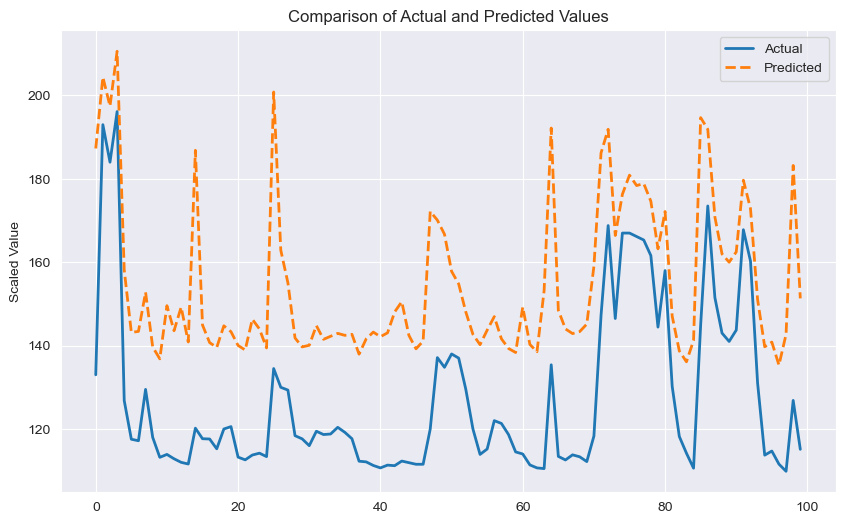

In [31]:
loaded_predictions = np.load('predictions.npy')
loaded_actuals = np.load('actuals.npy')

# 绘制预测值和实际值/
plt.figure(figsize=(10, 6))
plt.plot(loaded_actuals[:100], label='Actual', linewidth=2)
plt.plot(loaded_predictions[1:101], label='Predicted', linestyle='--', linewidth=2)
plt.title('Comparison of Actual and Predicted Values')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()

## Create a df to store the predictions and actuals and adjust the index

In [33]:
# create a df to store the predictions and actuals
pre_act_df = pd.DataFrame()
pre_act_df['actuals'] = loaded_actuals
pre_act_df['predictions'] = loaded_predictions

# drop the first value in predictions, move the whole column up by one position, and fill the last value with nan
pre_act_df['predictions'] = pre_act_df['predictions'].shift(-1)
pre_act_df['predictions'].iloc[-1] = np.nan
pre_act_df

,actuals,predictions
0,133.000000,187.296844
1,193.000015,204.420563
2,184.000000,197.436813
3,196.153839,210.607101
4,126.818184,158.154022
...,...,...
376704,133.666672,187.486649
376705,128.250000,182.728973
376706,114.333336,166.623993
376707,111.500000,160.369019


Now the predictions and actuals are in the correct position. We can use the predictions to get the trading signals.

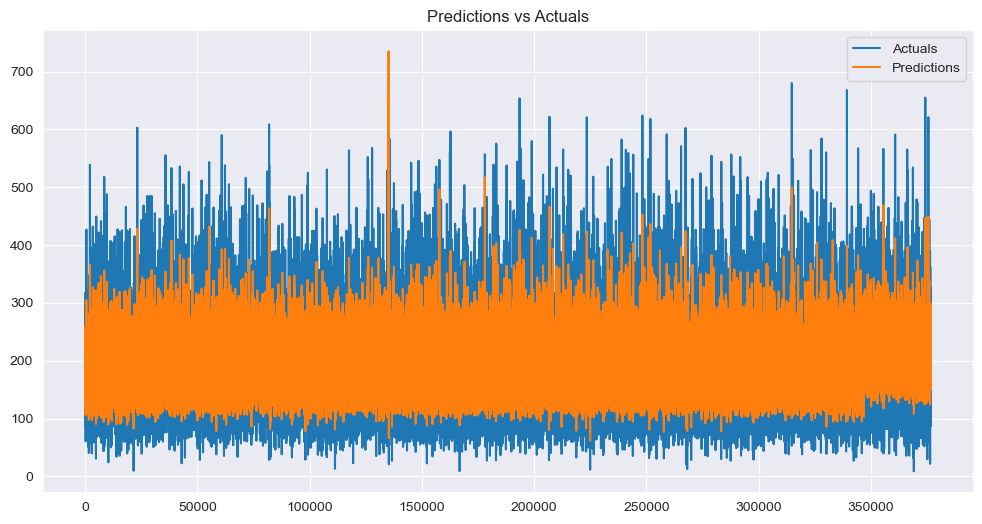

In [34]:
# now the index is correct.
plt.figure(figsize=(12, 6))
plt.plot(pre_act_df['actuals'], label='Actuals')
plt.plot(pre_act_df['predictions'], label='Predictions')
plt.title('Predictions vs Actuals')
plt.legend()
plt.show()